<a href="https://colab.research.google.com/github/Liang130520/Deep_Learning/blob/main/20221117_tf-keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import cv2 # 圖片讀取
import matplotlib.pyplot as plt # seaborn

import os # file path
from glob import glob # search files
from tqdm.auto import tqdm # progress bar

import tensorflow as tf
from tensorflow.keras import layers, models, utils

from sklearn.model_selection import train_test_split

#### Download dataset

In [40]:
# download from google drive
!gdown --fuzzy 1fIViA1w8MVJJZJcAjMwapHIYazuyTczE --output pneumonia.zip

In [41]:
# unzip dataset file
!unzip -q pneumonia.zip

#### Prepare dataset


In [42]:
IMG_SIZE = 200 # 256 128 64
all_class = ['normal', 'bacteria', 'virus']
class_map = {cls: i for i, cls in enumerate(all_class)} #  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [43]:
# read all paths
# *: all
img_paths_train = glob('pneumonia/train/*/*.jpeg') # glb 是搜尋資料, 此行 = 搜尋 pneumonia/train 裡所有的 jpeg 檔
# img_paths_train = glob('pneumonia/train/normal/*.jpeg') + glob('pneumonia/train/pneumonia/*.jpeg')

img_paths_test = glob('pneumonia/val/*/*.jpeg')

In [44]:
img_paths_train[:3]

['pneumonia/train/pneumonia/person1661_bacteria_4406.jpeg',
 'pneumonia/train/pneumonia/person1308_bacteria_3292.jpeg',
 'pneumonia/train/pneumonia/person1700_bacteria_4502.jpeg']

In [45]:
# number of images
len(img_paths_train), len(img_paths_test)

(150, 100)

pneumonia/train/pneumonia/person1661_bacteria_4406.jpeg
(347, 607, 3)


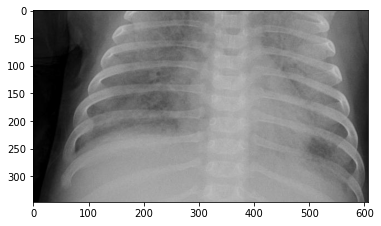

In [46]:
# show image
path = img_paths_train[0]
img = cv2.imread(path)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()


((347, 607, 3), (200, 200, 3))

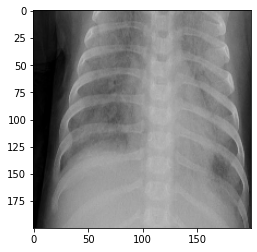

In [47]:
# Resize  img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [48]:
# Extract img class
# Linux 寫法, os.sep: /, 其他寫法, os.sep:"/"
print(path)
cls = path.split(os.sep)[-2]
print(cls)

pneumonia/train/pneumonia/person1661_bacteria_4406.jpeg
pneumonia


In [49]:
# Get file class index

# for pneumonia class
if cls == 'pneumonia':
    # get filename
    filename = path.split(os.sep)[-1]
    print(filename)
    # get pneumonia class
    cls_pneumonia = filename.split('_')[1] 
    print(cls_pneumonia)
    cls_idx = class_map[cls_pneumonia]
    print(cls_idx)
# for normal class
else:
    cls_idx = class_map[cls]

person1661_bacteria_4406.jpeg
bacteria
1


In [50]:
cls_idx

1

### Read all images

In [51]:
def read_data(paths):
    data_count = len(paths)
    x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 1)) # model input
    # x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3)) # 當作彩色圖片處理 model input
    y = np.zeros((data_count, )) # answer

    for i, path in enumerate(tqdm(paths)):
        # read image
        img = cv2.imread(path) # (H, W, 3)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize

        # To Grayscale: OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # (H, W, 3) -> (H, W)
        img = np.expand_dims(img, axis=-1) # (H, W) -> (H, W, 1)

        # # To Grayscale
        # img = img[:, :, :1] # (H, W, 3) -> (H, W, 1)

        # Normalization
        img = img / 255. # 0~255 -> 0~1

        # read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        if cls == 'pneumonia':
            # get filename
            filename = path.split(os.sep)[-1]
            # get pneumonia class
            cls_pneumonia = filename.split('_')[1] 
            cls_idx = class_map[cls_pneumonia]
        # for normal class
        else:
            cls_idx = class_map[cls]
            
        x[i] = img
        y[i] = cls_idx
    return x, y

In [52]:
x_train, y_train = read_data(img_paths_train)
x_test, y_test = read_data(img_paths_test)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
x_train.shape, y_train.shape

((150, 200, 200, 1), (150,))

In [54]:
# label count
print(all_class)
# train
unique_classes, counts = np.unique(y_train, 
                                   return_counts=True)
print(unique_classes, counts)

# test
unique_classes, counts = np.unique(y_test, 
                                   return_counts=True)
print(unique_classes, counts)

['normal', 'bacteria', 'virus']
[0. 1. 2.] [100  33  17]
[0. 1. 2.] [50 28 22]


In [55]:
# split train and test dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.2, # 80% : 20%
                                                  random_state=5566)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((120, 200, 200, 1), (30, 200, 200, 1), (120,), (30,))

In [56]:
y_train

array([1., 2., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 2., 1., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
       1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0.])

In [57]:
# one-hot encoding
y_train = utils.to_categorical(y_train, 
                               num_classes=len(class_map))
y_val = utils.to_categorical(y_val, 
                             num_classes=len(class_map))
y_test = utils.to_categorical(y_test, 
                              num_classes=len(class_map))

In [58]:
y_train.shape, y_val.shape, y_test.shape

((120, 3), (30, 3), (100, 3))

In [59]:
y_train[:10]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Build model

In [60]:
# 1: Functional API

# Encoder: Feature Extractor
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(filters=64, kernel_size=7, activation='relu')(inputs)
x = layers.Conv2D(filters=64, kernel_size=7, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(filters=128, kernel_size=7, activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size=7, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(filters=256, kernel_size=7, activation='relu')(x)
x = layers.Conv2D(filters=256, kernel_size=7, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Flatten()(x)
# Classifier
x = layers.Dense(64, activation='relu')(x)
prediction = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=prediction)

In [61]:
# 2
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', 
                         input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [62]:
# 3
model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', 
                  input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(3, activation='softmax'),
])

In [63]:
# 4: Subclass
class MyModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.encoder = models.Sequential([
            layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
            layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
            layers.MaxPool2D(2),
        ])
        self.flatten = layers.Flatten()
        # self.flatten = layers.GlobalAveragePooling2D()
        self.classifier = models.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(3, activation='softmax')               
        ])

    def call(self, x):
        print("Start call")
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    def features(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x

model = MyModel()
model.build((1, 200, 200, 1)) # (BS, 200, 200, 1)

Start call


In [64]:
imgs = np.random.normal(0, 1, size=(1, 200, 200, 1))

output = model(imgs)
# output = model.features(imgs)

output.shape

Start call


TensorShape([1, 3])

In [65]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 98, 98, 64)           37568     
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 sequential_3 (Sequential)   (1, 3)                    39338243  
                                                                 
Total params: 39,375,811
Trainable params: 39,375,811
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (1, 198, 198, 64)         640       
                                                                 
 conv2d_21 (Conv2D)          (1, 196, 196, 64)         36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (1, 98, 98, 64)          0         
 g2D)                                                            
                                                                 
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
_________________________________________________________________


### Training

In [67]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
            #   loss=tf.keras.losses.CategoricalCrossentropy(),
              
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [68]:
logs = model.fit(x_train, y_train,
                 batch_size=32,
                 epochs=30,
                 validation_data=(x_val, y_val),
                 )

Epoch 1/30
Start call
Start call
4/4 [==============================] - 5s 745ms/step - loss: 0.9996 - accuracy: 0.4250 - val_loss: 0.8978 - val_accuracy: 0.6667
Epoch 2/30
4/4 [==============================] - 0s 115ms/step - loss: 0.8353 - accuracy: 0.6667 - val_loss: 0.8285 - val_accuracy: 0.6667
Epoch 3/30
4/4 [==============================] - 0s 114ms/step - loss: 0.7899 - accuracy: 0.6667 - val_loss: 0.8080 - val_accuracy: 0.6667
Epoch 4/30
4/4 [==============================] - 0s 113ms/step - loss: 0.7534 - accuracy: 0.6667 - val_loss: 0.7642 - val_accuracy: 0.6667
Epoch 5/30
4/4 [==============================] - 0s 114ms/step - loss: 0.7367 - accuracy: 0.6833 - val_loss: 0.7490 - val_accuracy: 0.6667
Epoch 6/30
4/4 [==============================] - 0s 114ms/step - loss: 0.7188 - accuracy: 0.7167 - val_loss: 0.7455 - val_accuracy: 0.6667
Epoch 7/30
4/4 [==============================] - 0s 114ms/step - loss: 0.6605 - accuracy: 0.7333 - val_loss: 0.6460 - val_accuracy: 0.666

### Training logs

In [69]:
history = logs.history

In [70]:
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch+1)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  30
val loss  0.3436216413974762
val acc 0.8333333134651184


Text(0.5, 1.0, 'accuracy')

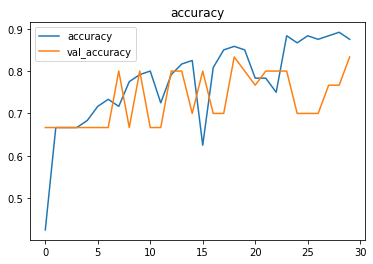

In [71]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

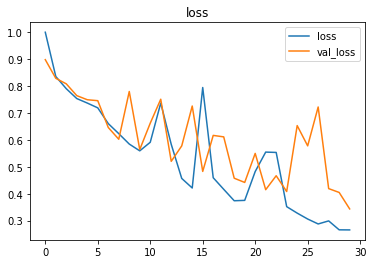

In [72]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

### Metrics

In [73]:
y_test[:3], np.argmax(y_test[:3], axis=-1)

(array([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=float32), array([2, 1, 1]))

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=-1) # [0, 1, 2, ...]

prediction = model.predict(x_test)
y_pred = np.argmax(prediction, axis=-1) # [0, 1, 2, ...]

print(y_true.shape, y_pred.shape)

Start call
4/4 [==============================] - 0s 99ms/step
(100,) (100,)


In [75]:
prediction[:3]

array([[0.06106712, 0.6405925 , 0.29834032],
       [0.69506156, 0.1528163 , 0.15212211],
       [0.07286323, 0.5289465 , 0.39819026]], dtype=float32)

In [76]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        50
           1       0.35      0.54      0.42        28
           2       0.00      0.00      0.00        22

    accuracy                           0.58       100
   macro avg       0.37      0.47      0.41       100
weighted avg       0.47      0.58      0.52       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# Confusion matrix:
#   row: Ground truth
#   column: predict
print(confusion_matrix(y_true, y_pred))

[[43  7  0]
 [13 15  0]
 [ 1 21  0]]


#### Save model

In [78]:
# 1. save whole model and weights
model.save('my_model.h5')

model2 = models.load_model('my_model.h5')
# mode1 = model2

NotImplementedError: ignored

In [ ]:
# 2. save and load weights only
model.save_weights('my_model_weights.h5')

# Rebuild model before load weights !
model2 = build_model()
model2.load_weights('my_model_weights.h5')

# model = model2

#### Callbacks

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

model.fit(callbacks=[]
          )

#### Tensorflow Addons

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

In [ ]:
# (None, 100, 100, 16)
# (batch_size, H, W, C) -> 4D
# (batch_size, HxW, C) -> 3D
# (N, HxW, C)

In [ ]:
# Conv, BN, Activation
class ConvBN(layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.conv = layers.Conv2D(filters, kernel_size)
        self.normalization = layers.BatchNormalization()
        self.act = layers.LeakyReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.normalization(x)
        return self.act(x)

layer = ConvBN(32, 5)    

In [ ]:
outputs = layer(imgs)

In [ ]:
outputs.shape

In [ ]:
import tensorflow as tf

class MyModel2(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.encoder = models.Sequential([
            ConvBN(63, 3),
            ConvBN(63, 3),
            layers.MaxPool2D(2),
        ])
        self.flatten = layers.GlobalAveragePooling2D()
        self.classifier = models.Sequential([
            layers.Dense(3, activation='softmax')               
        ])

    def call(self, x):
        print("Start call")
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    def features(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x

In [ ]:
model = MyModel2()

In [ ]:
imgs = np.random.normal(0, 1, (100, 128, 128, 1))

outputs = model(imgs)

In [ ]:
outputs.shape